## Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [10]:
# Please fill in your names here
NAME_STUDENT_1 = "Ylja Remmits"
NAME_STUDENT_2 = "Jan Blans"

In [11]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all" 
HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [12]:
from sklearn.model_selection import *
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 
- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

In [13]:
def plot_svm_kernels(X, Y):
    # figure number
    fignum = 1

    # fit the model
    for kernel in ('linear', 'poly', 'rbf'):
        print(kernel)
        clf = svm.SVC(kernel=kernel)
        clf.fit(X, Y)

        # plot the line, the points, and the nearest vectors to the plane
        plt.figure(fignum, figsize=(15, 10))
        plt.suptitle('kernel = %s' % kernel)

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                    s=85, edgecolors='k', c='w', zorder=10)
        plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.bwr)

        for i, coef in enumerate(clf.dual_coef_[0]):
            plt.annotate("%0.2f" % (coef), (clf.support_vectors_[i, 0]+0.15,clf.support_vectors_[i, 1]), fontsize=8, zorder=11)

        plt.axis('tight')
        x_min = -3
        x_max = 3
        y_min = -3
        y_max = 3

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(4, 3))
        #plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.bwr, alpha=0.1)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
    plt.show()

linear : accuracy on training set: 0.553
linear : accuracy on test set: 0.547
rbf : accuracy on training set: 0.901
rbf : accuracy on test set: 0.914
poly : accuracy on training set: 0.643
poly : accuracy on test set: 0.635
linear
poly
rbf


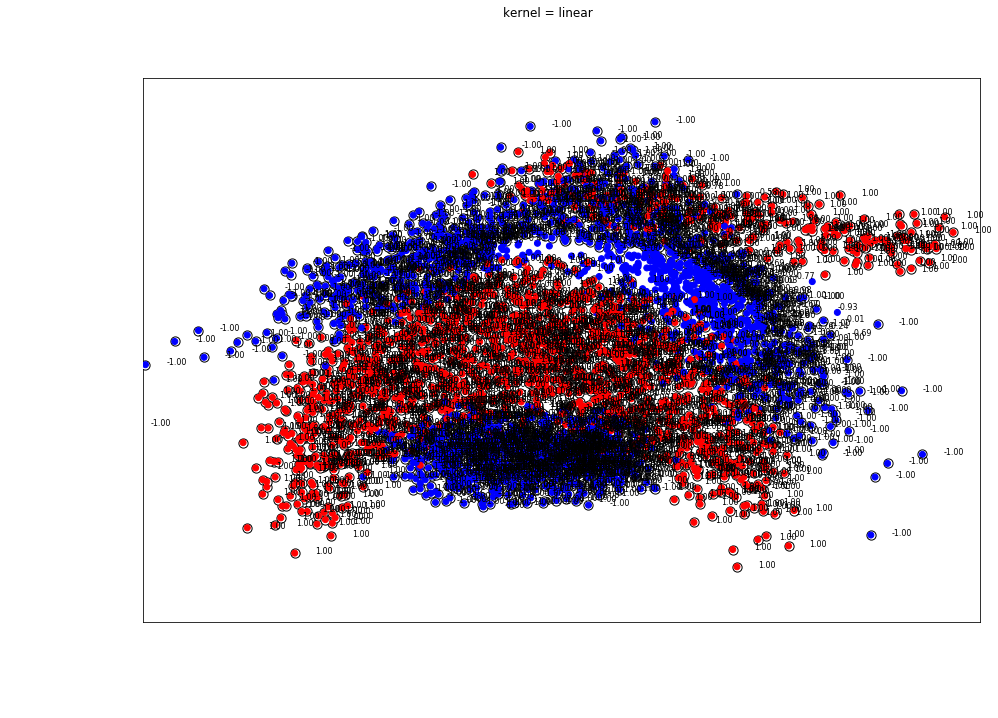

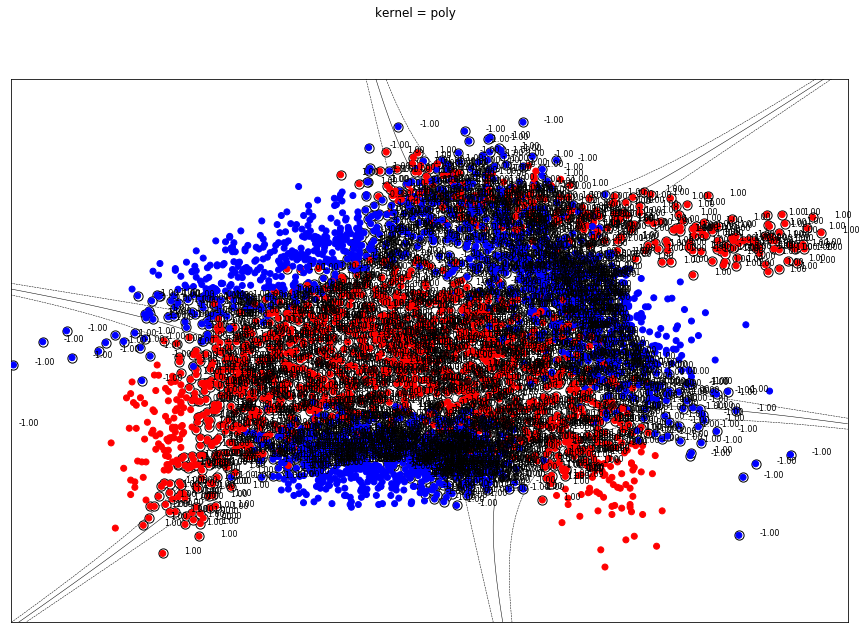

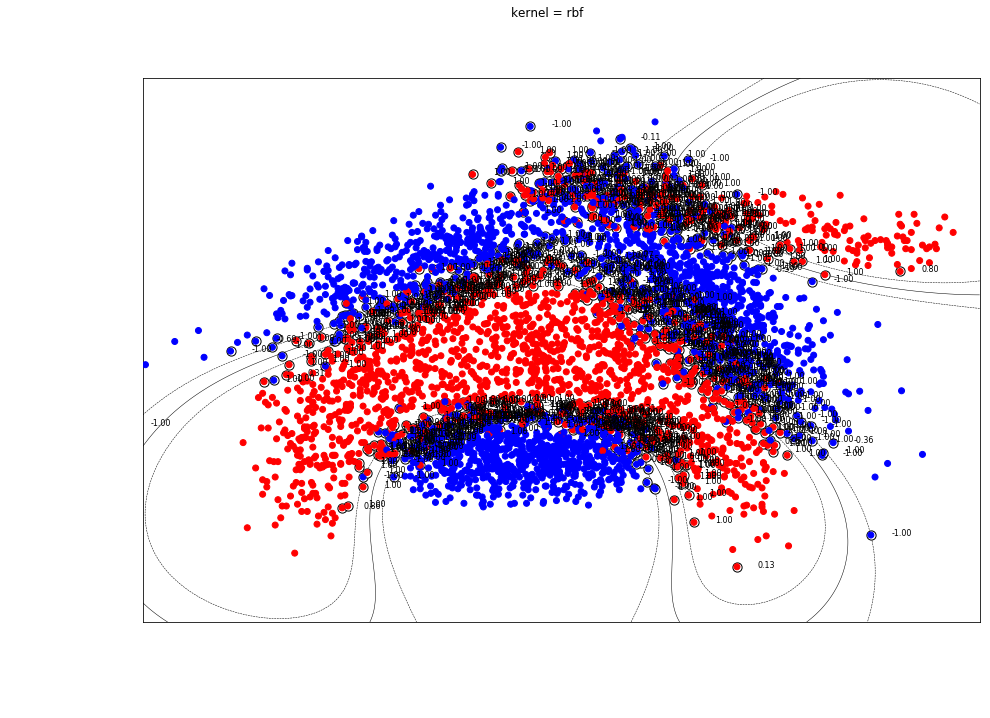

In [14]:
from sklearn import svm
import plot_classifiers
kernels = ['linear', 'rbf',  'poly']
classifiers = []

for k in kernels:
    svc = svm.SVC(kernel=k)
    svc.fit(X_train, y_train)
    classifiers.append((k,svc))
    print(k, ": accuracy on training set: {:.3f}".format(svc.score(X_train, y_train)))
    print(k, ": accuracy on test set: {:.3f}".format(svc.score(X_test, y_test))) 

plot_svm_kernels(X_train, y_train)
# plot_classifiers.plot_classifiers(kernels, classifiers, figuresize=(20,8)) 

AUC for linear: 0.506
Number of suppor vectors linear: 3613
AUC for rbf: 0.970
Number of suppor vectors rbf: 1180
AUC for poly: 0.755
Number of suppor vectors poly: 3218


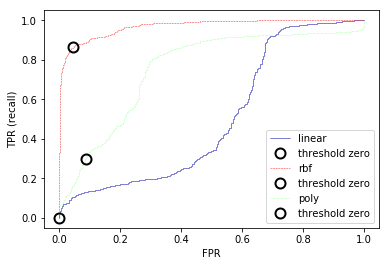

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

for kernel, svc in classifiers:
    fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

    plt.plot(fpr, tpr, label=kernel)
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
             label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4);

    svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
    print("AUC for {}: {:.3f}".format(kernel,svc_auc))
    print("Number of suppor vectors {}: {}".format(kernel, len(svc.support_vectors_)))

# 1.1

* When we look at the basic kernels with their default hyperparameters we see that the `rbf` function works best. It has an AUC score of 0.970 compared to the 0.506 of `linear` and 0.755 of `poly`. Therefor we conclude that the `rbf` kernel works best.
* In the case of `rbf` the kernel is able to fit the data very well. We see that the True Positive Rate increases quickly, which is ideal. The other two kernels do not perform as good. Thier TPR increases slowly as the FPR increases. 

2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

In [16]:
from mglearn.plot_2d_separator import plot_2d_separator
from mglearn.plot_helpers import discrete_scatter

def plot_svm(X, X_test, y, y_test, log_C, log_gamma, ax=None):
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svc = svm.SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    plot_2d_separator(svc, X, ax=ax, eps=.5)
    # plot data
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    # plot support vectors
    sv = svc.support_vectors_
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svc.dual_coef_.ravel() > 0
    discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, ax=ax)
    ax.set_title("C = %.4f gamma = %.4f" % (C, gamma))
    svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))
    print("AUC for C = {} and Gamma = {}: {:.3f}".format(C, gamma, svc_auc))
    print("Number of suppor vectors: {}".format(len(svc.support_vectors_)))
        

AUC for C = 0.1 and Gamma = 0.1: 0.682
Number of suppor vectors: 3363
AUC for C = 0.1 and Gamma = 1.0: 0.968
Number of suppor vectors: 1517
AUC for C = 0.1 and Gamma = 10.0: 0.965
Number of suppor vectors: 1640
AUC for C = 1.0 and Gamma = 0.1: 0.903
Number of suppor vectors: 2776
AUC for C = 1.0 and Gamma = 1.0: 0.972
Number of suppor vectors: 1036
AUC for C = 1.0 and Gamma = 10.0: 0.956
Number of suppor vectors: 1062
AUC for C = 1000.0 and Gamma = 0.1: 0.968
Number of suppor vectors: 1025
AUC for C = 1000.0 and Gamma = 1.0: 0.969
Number of suppor vectors: 874
AUC for C = 1000.0 and Gamma = 10.0: 0.957
Number of suppor vectors: 872


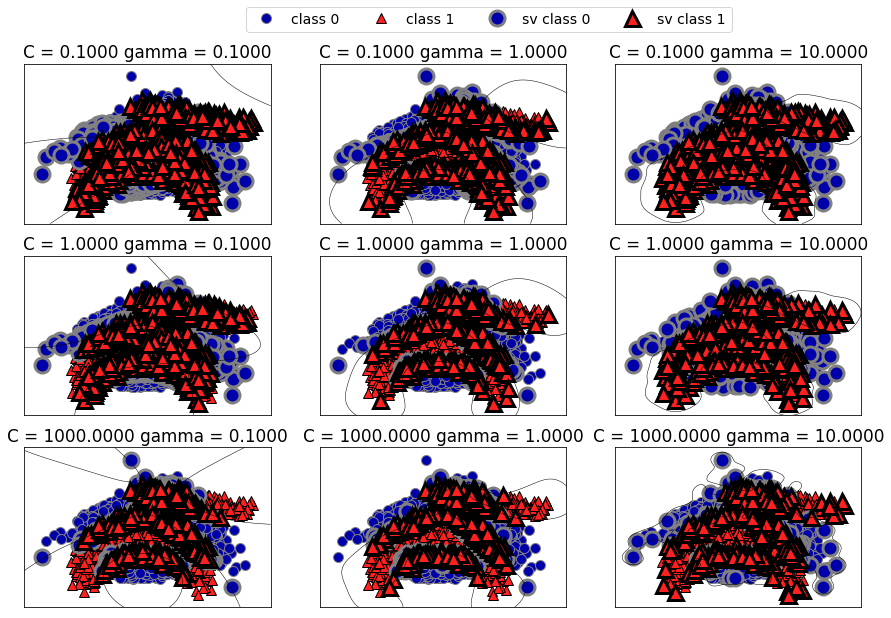

In [17]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(X_train, X_test, y_train, y_test, log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2));

In [ ]:
values = np.logspace(-15, 15, 10, base=2)
scores = []
for C in values:
    for gamma in values:
        svc = svm.SVC(C=C,gamma=gamma)
        scores.append(cross_val_score(svc, X, y, cv=10).mean())
mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C', cmap="viridis", xticklabels = values, yticklabels = values);

# 1.2

* For the combination of manually chosen values, we get the following amounts of support vectors and AUC performances:
  * C = 0.1 and Gamma = 0.1, AUC: 0.682,
    #SV: 3363
  * C = 0.1 and Gamma = 1.0, AUVC 0.968,
    #SV: 1517
  * C = 0.1 and Gamma = 10.0, AUC 0.965,
    #SV: 1640
  * C = 1.0 and Gamma = 0.1, AUC 0.903,
    #SV: 2776
  * C = 1.0 and Gamma = 1.0, AUC 0.972,
    #SV: 1036
  * C = 1.0 and Gamma = 10.0, AUC 0.956,
    #SV: 1062
  * C = 1000.0 and Gamma = 0.1, AUC 0.968,
    #SV: 1025
  * C = 1000.0 and Gamma = 1.0, AUC 0.969,
    #SV: 874
  * C = 1000.0 and Gamma = 10.0, AUC 0.957, #SV: 872
* In the above results we can see that the values `C = 1` and `Gamma = 1` combined give the highest AUC number. This combination also has the biggest number of Support Vectors. `C` limits the weights of the support vectors. A small value of `C` implies more underfitting, and large value of `C` implies more overfitting. It is therefore reasonable that a value of `C = 1` gives a good result. A high value of `Gamma` leads more support vectors and therefore overfitting. We can see this in our results because the AUC results drop for all values of `C` as `Gamma` increases from 1.0 to 10

## Building Kernels (4 points (0.5+0.5+1+2))

Consider the artificial dataset given below. It represents a sine wave with added noise.

1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40]. 

    - Does it fit the data well? Does it extrapolate well (in the range [30,40])? Explain your findings. 
    - Can you get better results by tweaking the kernel or the other SVM parameters?
    
2. Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

      $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
    - Build an SVM regressor using that kernel by passing your kernel function as the `kernel` hyperparameter. 
    - Fit it on the sine data and plot the predictions on all data points. Interpret the results.
    
3. Since this data is periodic, it makes sense to implement a periodic kernel instead. 

    - This is the Exponential Sine Squared kernel, with length scale $\Gamma$ and periodicity $P$:
  $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$
    - Implement it, using the defaults $\Gamma=1$, periodicity $P=1$, and Euclidean distance.
    - Train an SVM regressor with it, fit in on the same data and plot the result. Interpret the outcome. 
    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility 
X = 30 * rng.rand(200, 1)
y = np.sin(X).ravel() 
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise

X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on
true_y = np.sin(X_plot) # and the 'true' target function

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y, c='red', lw=2);

In [ ]:
# RBF Model

from sklearn.svm import SVR

# Fit regression model
svr_rbf = SVR(kernel='rbf')
y_rbf = svr_rbf.fit(X, y).predict(X_plot)

# Look at the results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, y_rbf, color='cornflowerblue', lw=3, label='RBF model')
plt.plot(X_plot, true_y, c='red', lw=2);
plt.xlabel('Data')
plt.ylabel('target')
plt.title('RBF Support Vector Regression')
plt.legend()
plt.show()

# 2.1
The RBF kernel fits the data quite nicely. The regression however stop almost immediately after the data 'ends'. It hardly extrapolates. This could be caused by the fact that is has no periodicity in it and that it assumes the `y` values beeing zero. 

In [ ]:
# Tweaked RBF
# Fit regression model
svr_rbfII = SVR(kernel='rbf', C = 1, gamma = .1)
y_rbfII = svr_rbfII.fit(X, y).predict(X_plot)

# Look at the results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, y_rbfII, c='cornflowerblue', lw=3, label='New RBF model')
plt.plot(X_plot, true_y, c='red', lw=2);
plt.xlabel('Data')
plt.ylabel('target')
plt.title('New RBF Support Vector Regression')
plt.legend()
plt.show()

# 2.1
Tweaking the rbf-kernel results in a smoother function which follows the original sine even better than the untweaeked version. The Extrapolation however becomes worse. 

In [ ]:
# Build Own Linear Model
# Fit regression model

def my_lin(X,Y):
    return np.dot(X, Y.T)

svr_lin = SVR(kernel=my_lin)
y_lin = svr_lin.fit(X, y).predict(X_plot)

# Look at the results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c = 'k', label='data')
plt.plot(X_plot, y_lin, c = 'orange', label='Linear model')
plt.plot(X_plot, true_y, c = 'red', lw=2);
plt.xlabel('Data')
plt.ylabel('target')
plt.title('Linear Support Vector Regression')
plt.legend()
plt.show()

# 2.2
The kernel return a straight line with a negative slope. This is cause by the fact that there are more datapoints in the bottom right quarter of the dataplane. If it were to fit the function correctly, the kernel would return a horinzontal line over the center amplitude of the sine function, in this case `y=0`.

In [ ]:
from cmath import pi
from scipy.spatial import distance

# Define Exponential Sine Squared Kernel
#  defaults Γ=1 , periodicity P=1, and Euclidean distance.

def build_ESS(G, P):
    def myESS(X,Y):
        return np.exp(-G*(np.sin((pi/P)*np.sqrt((np.subtract(X, Y.T))**2))))
    return myESS

ESS = SVR(kernel = build_ESS(G=1, P=35))

# Predict using ESS
y_ess = ESS.fit(X, y).predict(X_plot)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, true_y, c = 'red', lw=2);
plt.plot(X_plot, y_ess, color='navy', label='GPR')
plt.xlabel('Data')
plt.ylabel('target')
plt.title(' Exponential Sine Squared')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

# 2.3
* The Exponental Sine Squared kernel heavily overfits the data. The frequency of the new function is more than twice he size of the original function and the amplitude approximately 50 times larger.
* In this kernel `P` determines the frequency and `G` determines the length of the function or in this case the amplitude of the sine. 

In [ ]:
# Define Exponential Sine Squared Kernel
#  G = [0,1], P = [1,100]

def build_ESS(G, P):
    def myESS(X,Y):
        return np.exp(-G*(np.sin((pi/P)*np.sqrt((np.subtract(X, Y.T))**2))))
    return myESS

for G in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    for P in [1, 20, 40, 60, 80, 100]:
                         
        ESS = SVR(kernel = build_ESS(G, P))

        # Predict using ESS
        y_ess = ESS.fit(X, y).predict(X_plot)

        # Plot results
        plt.figure(figsize=(10, 5))
        plt.scatter(X, y, c='k', label='data')
        plt.plot(X_plot, true_y, c = 'red', lw=2);
        plt.plot(X_plot, y_ess, color='cornflowerblue', lw=2, label='ESS')
        plt.xlabel('Data')
        plt.ylabel('target')
        plt.title(' Exponential Sine Squared: Gamma={}, P={}'.format(G,P))
        plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
        plt.show()

# 2.3
When we look at different values we see that the kernels with `G=1, P=40` fits the data the best. When we tweak the values even further by hand. We get the best results for `G=1, P=35`

4 . We now make the problem a bit more challenging by adding an upward trend:

- Fit the same SVM using the optimal parameters from the previous subtask and plot the results. Do they still work? Explain what you see.
- Fit a Gaussian process (GP) using the kernels given below. First use the singular ExpSineSquared kernel (the implementation provided by sklearn this time), then build a new kernel consisting of the 3 components given below. Use both to predict all points for the "rising noisy sine" data and plot the results as usual. Interpret the results.
    - For the GP, it may help to use `normalize_y=True` since the y-values are not around 0. Setting `alpha=0.1` may help with possible numerical issues, otherwise keep it at 0.
- Also plot the _uncertainty interval_ around the predictions. You can ask the GP to return the standard deviation during prediction with the `return_std=True` hyperparameter. Plot a band 2 standard deviations above and below the prediction. You can use MatPlotLib's `fill_between` as shown in class.
    - You can combine the 3 models in one plot for easy comparison.
- We've provided reasonable values for the kernel hyperparameters above. Can you optimize them further to get an even better fit? Think about what the hyperparameters do and optimize the ones you think are most worth tuning.

In [ ]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, RBF

# Replace `length_scale` and `periodicity` with the values found in the previous part.
kernel_simple = ExpSineSquared(length_scale=1, periodicity=1) # periodic component

k1 = 4300 * RBF(length_scale=70.0)  # long term smooth rising trend
k2 = 6 * RBF(length_scale=90.0) * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.035)  # noise terms

## Bayesian updates (3 points (2+1))

We consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1000 points) and try to learn the (very noisy) trend. 

1. Train a Gaussian process on an increasing amount of samples of the training data. Use a simple RBF kernel:
`RBF(10, (1e-2, 1e2))`

 - Start with 10 _random_ samples and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Also compute $R^2$ on the training data.
 - Repeat and 10 more points, retrain and redraw. Do this a couple of times and interpret/explain what you see. 
 
2. Train the Gaussian on the full training set.

 - Plot the predictions (including the uncertainty interval) on the full dataset. Evaluate on the test set using $R^2$ 
 - Interpret the results. Is the kernel right? Is the GP under/overfitting?
 - Try to improve the results by tuning the kernel. Do this either manually or using a small grid/random search.

### 3.1 
We can see that the model overfits on the data. The test scores decrease when taking more samples. The uncertainty intarval remains quite wide even with increasing samples.

### 3.2 
With larger alpha the GP overfits less. This is amplified by larger length scale bounds for the kernel. The model with the best $R^2$ values for the test set might be an underfit. Looking at the shape of the data other models actually follow the shape better. To improve on the results, we could try adding bias or noise kernels, which was outside the scope of this exercise. The best fitting models do are not very certain. However, with such noisy data this is also what we would expect.

In [ ]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);

train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1500)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T
y_all = X[:1500].reshape(-1,1)

pd.Series(X[:1500,0]).plot()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
scores =[]

for n in range(10, 250, 10):
    idx = np.random.choice(X_train.shape[0], n, replace=False)
    X_tr = X_train[idx, :]
    y_tr = y_train[idx, :].ravel()
    # Instanciate a Gaussian Process model
    kernel =  RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X_tr, y_tr)
    train_score = gp.score(X_tr, y_tr)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(X_all, return_std=True)
    test_score = gp.score(X_test, y_test)
    scores.append(test_score)
    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure(figsize=(10,6))
    plt.plot(X_all, y_pred, 'r-', lw =2, label=u'Prediction')
    plt.fill(np.concatenate([X_all, X_all[::-1]]),    np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.plot(X_tr, y_tr, 'g.', markersize=10, label=u'Observations')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.title('nr of samples = {0:d}, train R^2 score = {1:5.2f}, test R^2 score = {2:5.2f}'.format(n,train_score,test_score))
    plt.legend(loc='upper left')
plt.figure()
plt.plot(range(10, 250, 10), scores)

In [ ]:
i=0
trainScores = []
testScores = []
for scale in range(2,5):
    alphaScores = []
    for alpha in [5e-3, 75e-4,1e-2, 25e-3 ,5e-2, 75e-3 ,1e-1, 5e-1, 1]:
#         print('length scale bounds e{0:d}, alpha {1:f}'.format(scale,alpha))
        kernel =  RBF(10, (10**-scale, 10**scale))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True,alpha=alpha)
        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(X_train, y_train.ravel())
        trainScores.append(gp.score(X_train, y_train.ravel()))
        # Make the prediction on the meshed x-axis (ask for MSE as well)
        y_pred, sigma = gp.predict(X_all, return_std=True)
        testScores.append(gp.score(X_test, y_test.ravel()))
        # Plot the function, the prediction and the 95% confidence interval based on
        # the MSE
        plt.figure(figsize=(20,15))
        plt.plot(X_all, y_all, 'y.', markersize=10, label=u'Observations')
        plt.plot(X_all, y_pred, 'r-', lw=3, label=u'Prediction')
        plt.fill(np.concatenate([X_all, X_all[::-1]]),    np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None', label='95% confidence interval')
        plt.xlabel('$x$')
        plt.ylabel('$f(x)$')
        plt.title('length scale bounds e{0:d}, alpha {1:f}, train R^2 {2:5.2f}, test R^2 {3:f}'.format(scale,alpha,trainScores[i],testScores[i]), fontsize = 20)
        plt.legend(loc='upper left', fontsize=20)
        i+=1

## A data mining challenge (4 points)

The goal here is to use everything you have learned to **build the best model for a given classification task**. We will use two tasks hosted on OpenML, so you will all receive the same cross-validation splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection, pipeline building, and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial. You need to optimize the **AUROC score** (calculated using 10-fold cross0-validation).

- Challenge 1: Detects accents in speech data.

    - The OpenML Task ID is 167132: https://www.openml.org/t/167132
    - The dataset description can be found here: https://www.openml.org/d/40910
    - Leaderboard: https://www.openml.org/t/167132#!people
    
- Challenge 2: Image recognition (CIFAR-10 subsample).

    - The OpenML Task ID is 167133: https://www.openml.org/t/167133
    - The dataset description can be found here: https://www.openml.org/d/40926
    - Leaderboard: https://www.openml.org/t/167133#!people
    - Note that this is a high-dimensional dataset (and not so small). Think carefully about how to run experiments in the  time available.
    
- You are able to see the solutions of others (by clicking in the timeline or run list), so you can learn from prior experiments (what seems to work, how long does it take to train certain models, ...). Resubmission of the exact same solution is not possible.
- You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- Document the different experiments that you ran in this notebook (running them can of course be done outside of the notebook). For each experiment, provide a description of how and why you chose the algorithms and parameters that you submitted. Reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows (independently for each task):

    - 1 point for the breadth of experiments you ran (algorithms, pipelines, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Exception: simply repeating top models with nearly identical hyperparameters. This will be checked on the timeline.
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the leaderboard.
        
Note: Report the AUC scores of your best models in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

### Both challenges
To be able to use roc_auc scores, we need to make scorer object of this. In this way we can pass this to the cross validation.

### Challenge 2
We experimented with scaling, transforming the data using PCA and fitting a random forrest and gradient boosting machines. The gradient boosting machine does not accept binarized labels, while the roc_auc scores requires this. Since this makes comparations useless, we decided to focus on the random forests. PCA did slow learning down. scaling slightly improved the results. However they were not near as good as those of our classmates.

In [ ]:
speech = oml.datasets.get_dataset(40910)
# Get the predictors X and the target y
X, y, attribute_names = speech.get_data(target=speech.default_target_attribute, return_attribute_names=True)
# Describe the data with pandas, just to get an overview
speechframe = pd.DataFrame(X, columns=attribute_names)
speechframe.describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(speechframe, y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

auc_scorer=make_scorer(roc_auc_score)

scalar = MinMaxScaler()

scalar.fit(X_train)
scalar.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train) 

print("kNN")
print("Training set score: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(knn, speechframe, y, cv=10)))
print("AUROC score: {}".format(cross_val_score(knn, speechframe, y, cv=10, scoring = auc_scorer)))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

auc_scorer=make_scorer(roc_auc_score)

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

print("Random Forest")
print("Training set score: {:.2f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rf.score(X_test, y_test)))
print("Cross-validation scores: {}".format(cross_val_score(rf, speechframe, y, cv=10)))
print("AUROC score: {}".format(cross_val_score(rf, speechframe, y, cv=10, scoring = auc_scorer)))

In [ ]:
from sklearn import svm

svc = svm.SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

print("Linear SVC")
print("Accuracy on training set: {}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {}".format(svc.score(X_test, y_test))) 
print("Cross-validation scores: {}".format(cross_val_score(svc, speechframe, y, cv=10)))
print("AUROC score:{}".format(roc_auc_score(y_test, svc.decision_function(X_test))))

In [ ]:
# from sklearn import ensemble, tree
# from pprint import pprint

# oml.config.apikey = '8f98971261e1a1ddfadaa08152abdcb2'

# # Get a task
# task = oml.tasks.get_task(14951)

# # Build any classifier or pipeline
# rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)

# # Create a flow
# flow = oml.flows.sklearn_to_flow(rf)

# # Run the flow 
# run = oml.runs.run_flow_on_task(task, flow)
# pprint(vars(run), depth =2)


In [ ]:
task = oml.tasks.get_task(167132)
pprint(vars(task))

In [ ]:
from sklearn import ensemble, tree
oml.config.apikey= '263477c0f7219360c5a68ae45ff4f5ce'
task = oml.tasks.get_task(167133)
pprint(vars(task))

In [ ]:
cifar = oml.datasets.get_dataset(40926)
# Get the predictors X and the target y
X, y, attribute_names = cifar.get_data(target=cifar.default_target_attribute, return_attribute_names=True)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV

In [ ]:
# param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

auc_scorer = make_scorer(roc_auc_score)

# Describe the data with pandas, just to get an overview
cifarframe = pd.DataFrame(X, columns=attribute_names)
yb = LabelBinarizer().fit_transform(y)
pipe = Pipeline([("scaler", MinMaxScaler()), ("decomposition", PCA()), ("rfc", RandomForestClassifier())])
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring = auc_scorer)
# grid.fit(X_train, y_train)
# print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
# print("Best parameters: {}".format(grid.best_params_))
scores = cross_val_score(pipe, X, yb , scoring=auc_scorer, verbose = 10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))


In [ ]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("rfc", RandomForestClassifier())])
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring = auc_scorer)
# grid.fit(X_train, y_train)
# print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
# print("Best parameters: {}".format(grid.best_params_))
scores = cross_val_score(pipe, X, yb , scoring=auc_scorer, verbose = 10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

In [ ]:
pipe = Pipeline([("decomposition", PCA()), ("rfc", RandomForestClassifier())])
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring = auc_scorer)
# grid.fit(X_train, y_train)
# print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
# print("Best parameters: {}".format(grid.best_params_))
scores = cross_val_score(pipe, X, yb , scoring=auc_scorer, verbose = 10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

In [ ]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("rfc", RandomForestClassifier(n_estimators=100))])
# grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring = auc_scorer)
# grid.fit(X_train, y_train)
# print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
# print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
# print("Best parameters: {}".format(grid.best_params_))
scores = cross_val_score(pipe, X, yb , scoring=auc_scorer, verbose = 10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))